# West Nile Virus Data Story_DataAnalysis
https://www.kaggle.com/c/predict-west-nile-virus


In [195]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "white")
import plotly
from scipy import stats 
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn import svm
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
% matplotlib inline

In [196]:
# load data 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
spray = pd.read_csv('spray.csv')
weather = pd.read_csv('weather.csv')
train_label = train['WnvPresent']

### Extract Zip code 

In [197]:
# extract zip code from Address column and add to column 'Zipcode'
import re
def address2zip(address):
    extzip = re.match('^.*(?P<zipcode>\d{5}).*$', address)
    if extzip is None:
        zipcode = 'na'
    else:
        zipcode = extzip.groupdict()['zipcode']
    return zipcode


# add zipcode column to train dataset
def addzip2df(df):
    zipcodes =[]
    rownum = df.shape
    rownum = rownum[0]
    for i in range(0,rownum):
        add = df.iloc[i]['Address']
        z = address2zip(add)
        zipcodes.append(z)
    df['Zipcode'] = zipcodes
    return df
    
traindf = addzip2df(train)
testdf = addzip2df(test)

### Extract Year, Month and Day

In [198]:
# train data
traindf['Year'] = pd.DatetimeIndex(traindf['Date']).year
traindf['Month'] = pd.DatetimeIndex(traindf['Date']).month
traindf['Day'] = pd.DatetimeIndex(traindf['Date']).day

### Convert categorical column to dummy variables

In [199]:
col_to_dummy = ['Year','Month','Day','Species','Zipcode','Block','Street','Trap']
traindfdummy = pd.get_dummies(traindf,columns = col_to_dummy)
#testdfdummy = pd.get_dummies(testdf,columns = ['Species','zipcode'])

### Check number of na values in each variables
There is no NaNs in traindfdummy 

In [200]:
x = traindfdummy.isnull().sum(axis=1).tolist()
y = float(sum(x))/(traindfdummy.shape[0]*traindfdummy.shape[1])
print 'Fraction nulls = ',y

Fraction nulls =  0.0


### Specify the columns need to be dropped

In [201]:
# drop columns with more than half null values
cols_to_drop =[]
for i in traindfdummy.columns:
    if 1.0*traindfdummy[i].isnull().sum()/len(traindfdummy[i]) >=0.5:
        cols_to_drop.append(i)

# Drop variable NumMosquitos
cols_to_drop.append('NumMosquitos')
# Drop address information since some dummy varialbes already included that information
cols_to_drop.extend(['Date','Address','AddressNumberAndStreet'])
        
trainpredict = traindfdummy.drop(cols_to_drop,axis=1)

### Correlation between variables

In [202]:
corr = trainpredict.corr()

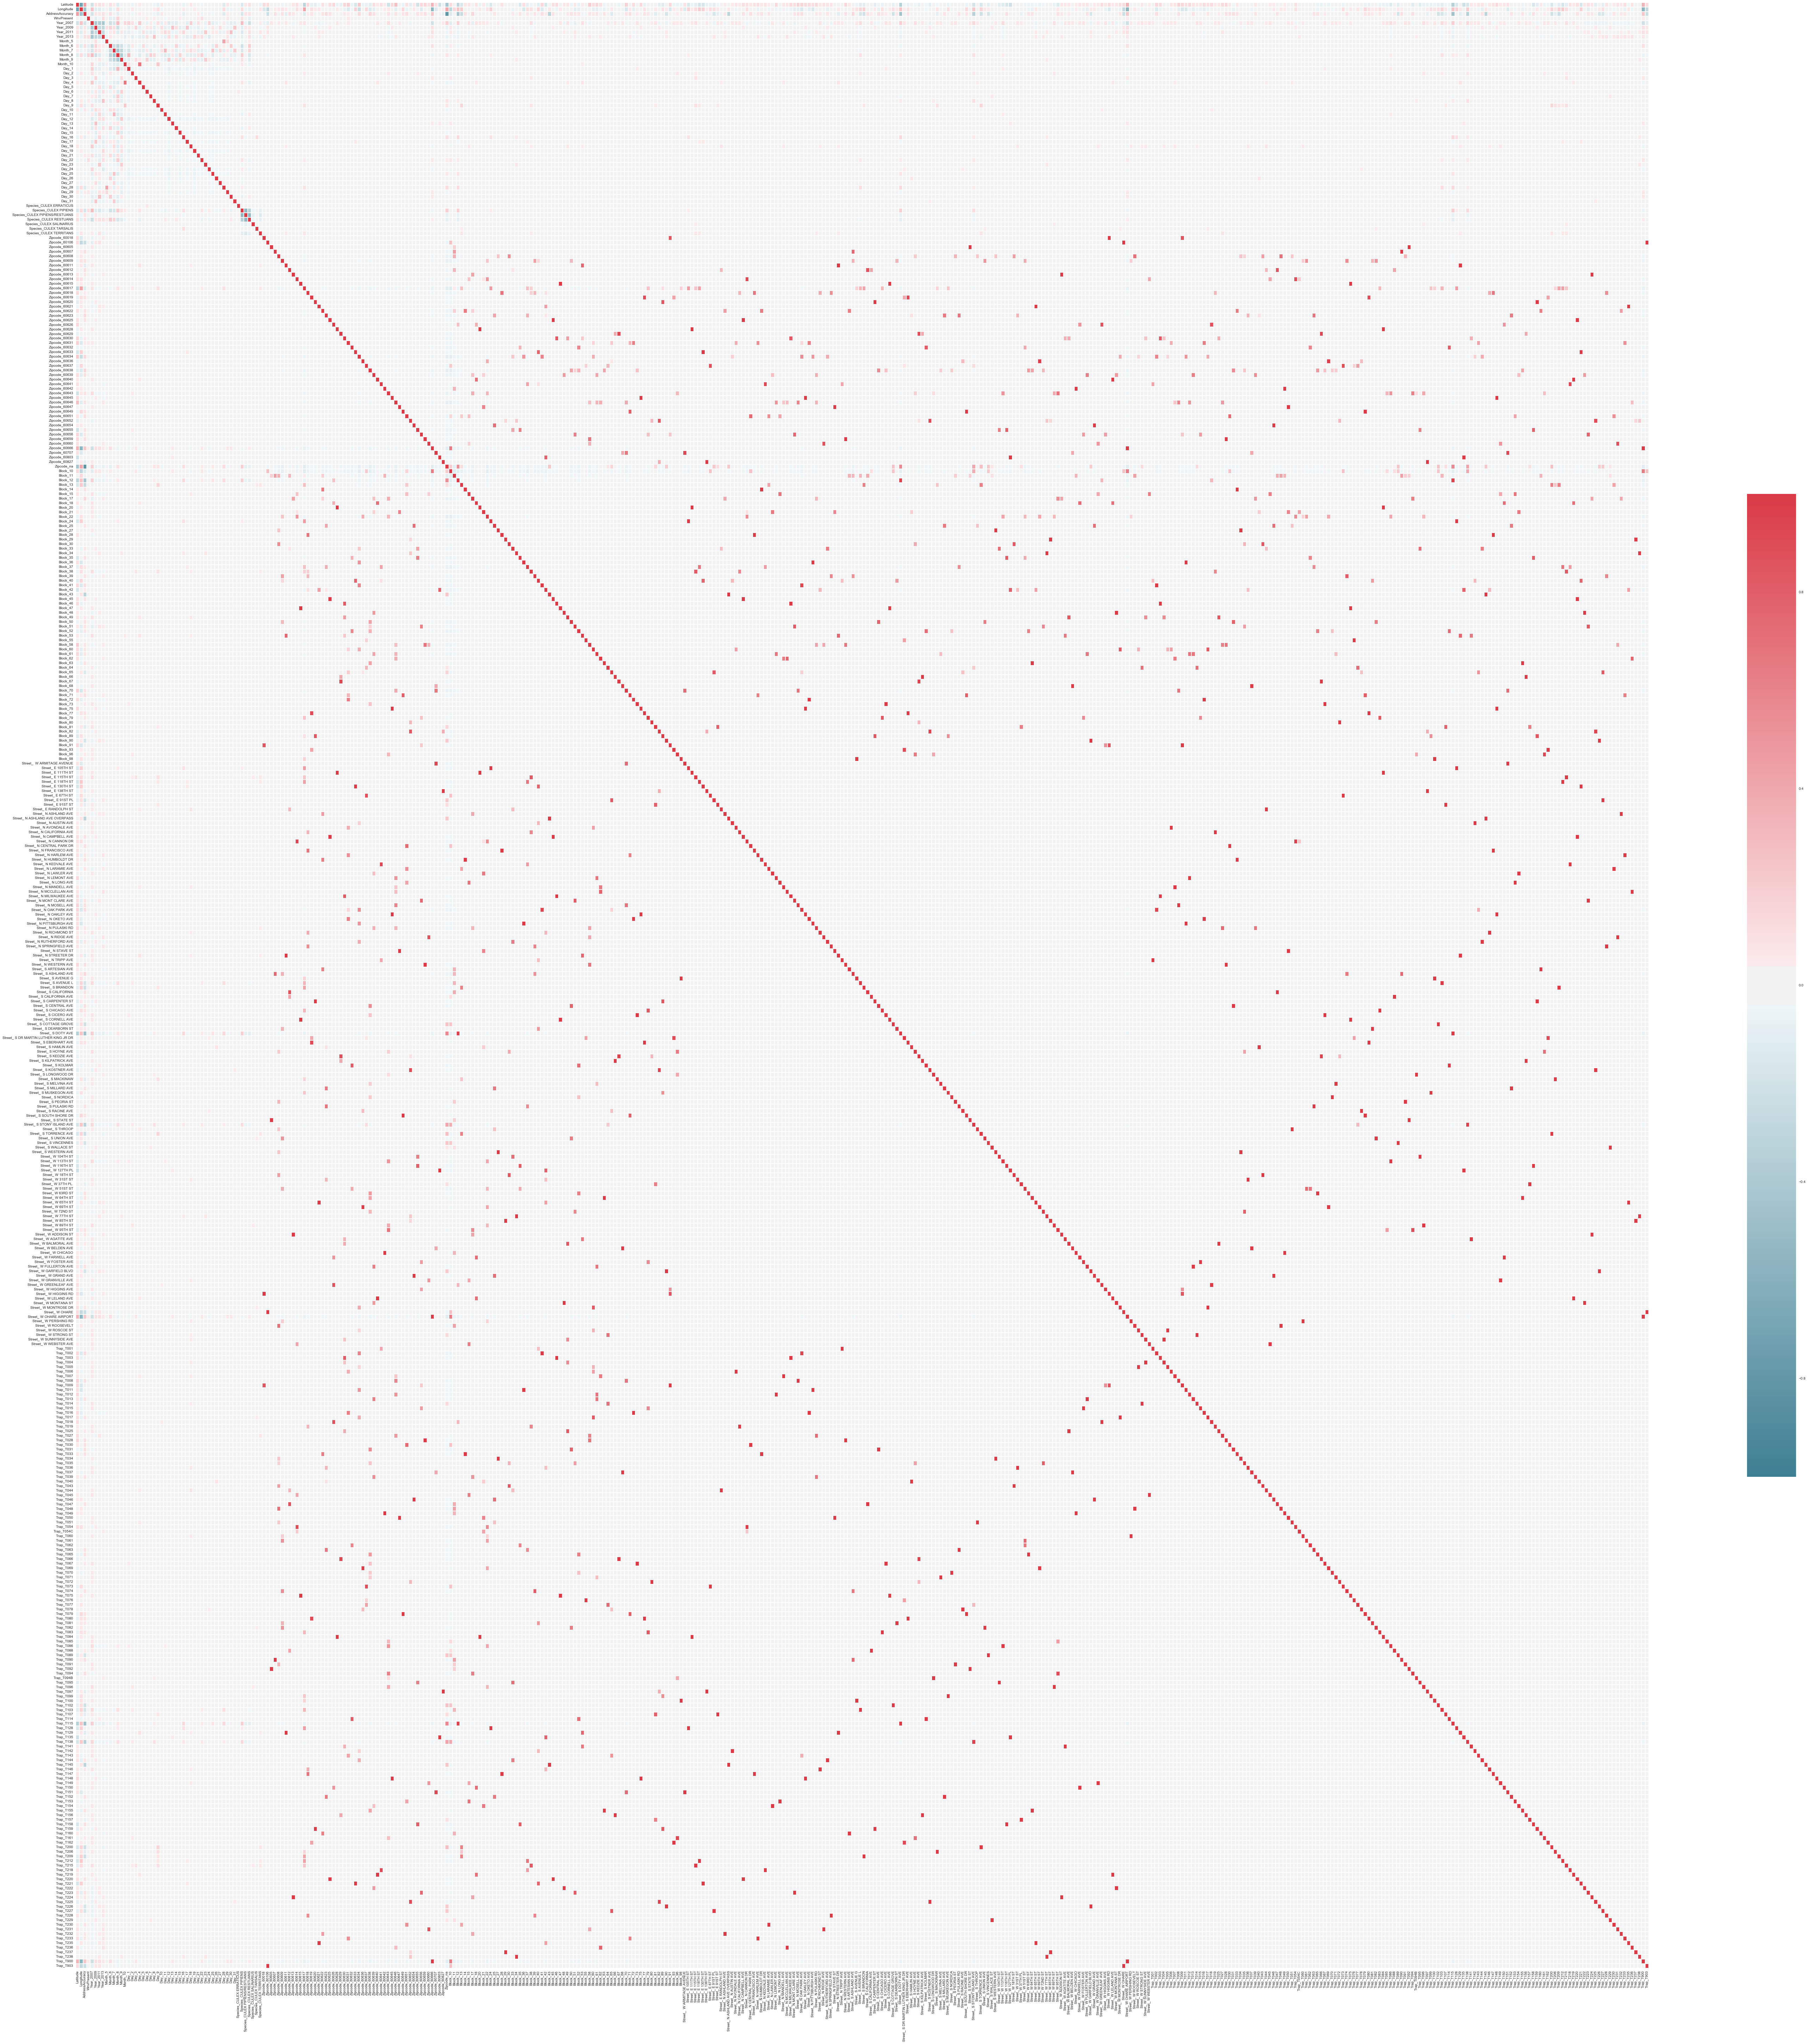

In [203]:
# correlation between numerical varialbes
fig, ax = plt.subplots(figsize = (100,100))
cmap = sns.diverging_palette(220,10,as_cmap = True)
sns.heatmap(corr, cmap = cmap, ax = ax, linewidths=1, cbar_kws ={'shrink': 0.5})
plt.show()

In [204]:
print trainpredict.shape
print trainpredict.columns
dfresponse = trainpredict['WnvPresent']
dfpredict = trainpredict.drop('WnvPresent',axis = 1)
print dfpredict.columns

(10506, 430)
Index([u'Latitude', u'Longitude', u'AddressAccuracy', u'WnvPresent',
       u'Year_2007', u'Year_2009', u'Year_2011', u'Year_2013', u'Month_5',
       u'Month_6',
       ...
       u'Trap_T230', u'Trap_T231', u'Trap_T232', u'Trap_T233', u'Trap_T235',
       u'Trap_T236', u'Trap_T237', u'Trap_T238', u'Trap_T900', u'Trap_T903'],
      dtype='object', length=430)
Index([u'Latitude', u'Longitude', u'AddressAccuracy', u'Year_2007',
       u'Year_2009', u'Year_2011', u'Year_2013', u'Month_5', u'Month_6',
       u'Month_7',
       ...
       u'Trap_T230', u'Trap_T231', u'Trap_T232', u'Trap_T233', u'Trap_T235',
       u'Trap_T236', u'Trap_T237', u'Trap_T238', u'Trap_T900', u'Trap_T903'],
      dtype='object', length=429)


### Baseline

In [205]:
# create a training and test dat set. 
X_train, X_test, y_train, y_test = train_test_split(dfpredict,dfresponse,test_size = 0.2)
print X_train.shape, X_test.shape, y_train.shape, y_test.shape
# predict all accepted
print 'Accuracy when predicting all with virus = ', metrics.accuracy_score(y_test, np.ones(y_test.shape))
# predict all rejected
print 'Accuracy when predicting all without virus = ', metrics.accuracy_score(y_test,np.zeros(y_test.shape))

(8404, 429) (2102, 429) (8404L,) (2102L,)
Accuracy when predicting all with virus =  0.0542340627973
Accuracy when predicting all without virus =  0.945765937203


### Logistic Regression

In [206]:
cdict = {}
for c in [0.001,0.01,0.1,1,10,100,1000]:
    clf = linear_model.LogisticRegression(C=c)
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
    cdict[c] = scores.mean()

In [207]:
print cdict
best_c = max(cdict, key=cdict.get)
print 'Best parameter: ', best_c, cdict[best_c]
clflog = linear_model.LogisticRegression(C=best_c)
clflog.fit(X_train,y_train)
predicted = clflog.predict(X_test)
print 'Accuracy on test set: ',metrics.accuracy_score(y_test, predicted)

{1: 0.94764410282543454, 100: 0.94645447596398857, 0.1: 0.94800110412773897, 1000: 0.94633542834494089, 10: 0.94693024177566387, 0.001: 0.94800110412773897, 0.01: 0.94800110412773897}
Best parameter:  0.1 0.948001104128
Accuracy on test set:  0.945765937203


Logistic Reression prediction is no better than baseline accuracy. They are exactly the same? How come?

### Random Forest

In [208]:
ntdict = {}
for nt in [100,250,500,1000,2500]:
    clf = RandomForestClassifier(n_estimators=nt,criterion="gini")
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    ntdict[nt] = scores.mean()

In [209]:
print ntdict
best_nt = max(ntdict, key=ntdict.get)
print 'Best parameter: ',best_nt, ntdict[best_nt]
clfRF_gini = RandomForestClassifier(n_estimators=nt)
clfRF_gini.fit(X_train,y_train)
predicted = clfRF_gini.predict(X_test)
print 'Accuracy on test set: ',metrics.accuracy_score(y_test,predicted)

{1000: 0.94514551837381799, 500: 0.94478922484570516, 250: 0.94455056338825649, 100: 0.94407451446690449, 2500: 0.94478894173602845}
Best parameter:  1000 0.945145518374
Accuracy on test set:  0.941960038059


In [210]:
# repeat using entropy instead of gini
ntdict = {}
# We added 5000 because a few times, the optimal number of trees was on the edge
for nt in [250,500,1000,2500,5000]:
    clf = RandomForestClassifier(n_estimators=nt,criterion="entropy")
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    ntdict[nt] = scores.mean()
print ntdict
best_nt = max(ntdict, key=ntdict.get)
print 'Best parameter: ',best_nt, ntdict[best_nt]
clfRF_ent = RandomForestClassifier(n_estimators=nt)
clfRF_ent.fit(X_train,y_train)
predicted = clfRF_ent.predict(X_test)
print 'Accuracy on test set: ',metrics.accuracy_score(y_test,predicted)

{1000: 0.94514580148349459, 2500: 0.94467003567181929, 250: 0.94443222354340062, 500: 0.94502661230960894, 5000: 0.94550266123096094}
Best parameter:  5000 0.945502661231
Accuracy on test set:  0.941484300666


### Decision Tree

In [211]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
predicted = dt.predict(X_test)
print 'Accuracy on test test:', metrics.accuracy_score(y_test, predicted)

Accuracy on test test: 0.921979067555


### K-Nearest Neighbours

In [212]:
kdict = {}
for k in [10,15,20,25,30,35]:
    clf = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    kdict[k] = scores.mean()
print kdict
best_k = max(kdict, key=kdict.get)
print 'Best parameter: ',best_k, kdict[best_k]
clfknn = KNeighborsClassifier(n_neighbors=best_k)
clfknn.fit(X_train,y_train)
predicted = clfknn.predict(X_test)
print 'Accuracy on test set: ', metrics.accuracy_score(y_test,predicted)

{35: 0.94800110412773897, 10: 0.94788262272804469, 15: 0.94800124568257738, 20: 0.94812015174678665, 25: 0.94800110412773897, 30: 0.94800110412773897}
Best parameter:  20 0.948120151747
Accuracy on test set:  0.945765937203


### SVM

In [213]:
cdict = {}
for c in [0.0001,0.001,0.01,0.1,1,10]:
    clf = svm.LinearSVC(loss="hinge",C=c);
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    cdict[c] = scores.mean()
print cdict
best_c = max(cdict, key=cdict.get)
print 'Best parameter: ', best_c, cdict[best_c]
clf = svm.LinearSVC(loss="hinge",C=best_c);
clf.fit(X_train,y_train)
predicted = clf.predict(X_test)
print 'Accuracy on test set: ',metrics.accuracy_score(y_test,predicted)

{1: 0.60204900628503488, 0.1: 0.94800110412773897, 10: 0.94800110412773897, 0.001: 0.94800110412773897, 0.0001: 0.94800110412773897, 0.01: 0.94800110412773897}
Best parameter:  0.1 0.948001104128
Accuracy on test set:  0.945765937203


In [214]:
cdict = {}
for c in [0.001,0.01,0.1,1,10,100,1000]:
    clf = svm.SVC(C=c);
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    cdict[c] = scores.mean()
print cdict
best_c = max(cdict, key=cdict.get)
print 'Best parameter: ',best_c, cdict[best_c]
clfsvm = svm.SVC(C=best_c);
clfsvm.fit(X_train,y_train)
predicted = clfsvm.predict(X_test)
print 'Accuracy on test set: ',metrics.accuracy_score(y_test,predicted)

{1: 0.94800110412773897, 100: 0.94800110412773897, 0.1: 0.94800110412773897, 1000: 0.94800110412773897, 10: 0.94800110412773897, 0.001: 0.94800110412773897, 0.01: 0.94800110412773897}
Best parameter:  1 0.948001104128
Accuracy on test set:  0.945765937203


### Adaboost

In [215]:
from sklearn.ensemble import AdaBoostClassifier
ndict={}
for n in [50,100,150,200,250]:
    clf = AdaBoostClassifier(n_estimators=n);
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    ndict[n] = scores.mean()
print ndict
best_n = max(ndict, key=ndict.get)
print 'Best parameter: ',best_n, ndict[best_n]
clfada = AdaBoostClassifier(n_estimators=best_n);
clfada.fit(X_train,y_train)
predicted = clfada.predict(X_test)
print 'Accuracy on test set: ', metrics.accuracy_score(y_test,predicted)

{200: 0.94478809240699846, 50: 0.94597800237812135, 100: 0.94562128418549352, 250: 0.9444312326595321, 150: 0.94526385821867387}
Best parameter:  50 0.945978002378
Accuracy on test set:  0.942435775452
